In [2]:
%matplotlib inline 


from collections import defaultdict
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # el pandas lo usamos para ordenar las palabras mas cercanas, cuando usamos la metrica del LSA
from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec 
from gensim.matutils import cossim
from nltk.corpus import stopwords
import pickle


# Cleaning

In [4]:
corpus_file = open("tasa", "r").read() # leemos tasa
documents = corpus_file.split("\n\n") # construimos una lista de documentos
documents[1234] # vemos como ejemplo el documento nº 1234

"[Baine53.05.01] [P#=1] [DRP=53.614433] [Science=Yes]  \n[S] who needs to know about weather? \n[S] what factors affect the weather?  \n[S] how would you describe the weather in the picture? \n[S] how did you  decide what to wear to school today? \n[S] what will you do after school  today? \n[S] often what you wear and what you do depend on the weather.  \n[S] a sudden change in weather may change your plans. \n[S] everyone is  affected by the weather. \n[S] weather is important to everyone. \n[S] weather  is the condition of the air around us. \n[S] the air is always changing.  \n[S] it becomes warmer or colder. \n[S] the wind changes speed and direction.  \n[S] air can be moist or dry. \n[S] all of these factors are part of weather.  \n[S] learning about air will help you understand the weather. \n[S] a blanket  of air called the atmosphere surrounds the earth. \n[S] the atmosphere is  a mixture of gases in several layers. \n[S] it extends from the earth's  surface to about 800 km ab

In [10]:
# Ejemplo de limpieza de un documento
reg_cor = re.compile("\[.*\]") #busca cosas entre corchetes
reg_num = re.compile(r"\s\d+[.,]?\d*\s") #busca numeros con o sin puntos o comas
document = documents[1234]
# replace reemplaza elementos del string por otros
# sub() hace lo mismo pero permite trabajar con expresiones regulares
reg_num.sub(" num ",reg_cor.sub("",document[document.find("\n[S]"):]).replace("\n", " "))  

"  who needs to know about weather?   what factors affect the weather?    how would you describe the weather in the picture?   how did you  decide what to wear to school today?   what will you do after school  today?   often what you wear and what you do depend on the weather.    a sudden change in weather may change your plans.   everyone is  affected by the weather.   weather is important to everyone.   weather  is the condition of the air around us.   the air is always changing.    it becomes warmer or colder.   the wind changes speed and direction.    air can be moist or dry.   all of these factors are part of weather.    learning about air will help you understand the weather.   a blanket  of air called the atmosphere surrounds the earth.   the atmosphere is  a mixture of gases in several layers.   it extends from the earth's  surface to about num km above the earth.   you have to run around a  football field about num times to go that far!   the layer of the  atmosphere closest t

In [13]:
# limpieza de todos los documentos del corpus
documents_clean = [reg_num.sub(" num ",reg_cor.sub("",document[document.find("\n[S]"):]).replace("\n", " ")) for document in documents] 
 

## tokenizando, filtrando por stoplist y por no-palabras

In [39]:
stoplist = stopwords.words('english')
texts=[[word for word in re.split(r'\W+', document.lower()) if word not in stoplist and word.isalpha()] for document in documents_clean]

In [40]:
# Vemos los primeros tokens del documento 1234 
texts[1234][:10]

['needs',
 'know',
 'weather',
 'factors',
 'affect',
 'weather',
 'would',
 'describe',
 'weather',
 'picture']

In [17]:
#Creates a frequency dictionary
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
        


In [18]:
frequency["zombies"] # el token "zombies" aparece una sola vez en todo el corpus

1

In [43]:
# Creacion de un diccionario que mapea tokens con Ids
dictionary = corpora.Dictionary(texts)

In [63]:
id_zombies = dictionary.token2id["zombies"] # token -> id
print id_zombies
print dictionary.id2token[id_zombies] # id -> token


66044
zombies


In [64]:
# Filtro palabras poco frecuentes (menores a 5) 
dictionary.filter_extremes(no_below=5, no_above=1, keep_n=100000)

In [65]:
dictionary.token2id["zombies"] # "zombies" fue filtrada

KeyError: 'zombies'

In [23]:
#save frequency
pickle.dump( frequency, open( "tasa_freq.p", "wb" ) )
# saving dictionary"
dictionary.save("tasa_dictionary.dict")
#Para cargar
#frequency = pickle.load( open( "tasa_freq.p", "rb" ) )
#dictionary = dictionary=corpora.Dictionary.load("tasa_dictionary.dict")

# Entrenamiento: transformacion tfidf + LSA

In [24]:
n_topics = 300
corpus = [dictionary.doc2bow(text) for text in texts]
print "Applying tfidf transformation"
tfidf = models.TfidfModel(corpus)  # tf-idf  transformation
corpus_tfidf = tfidf[corpus]
print "Applying LSA"
lsa_tfidf = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics = n_topics)  # initialize an LSI transformation
lsa_tfidf.save("LSA_tasa_"+str(n_topics)+".lsi") # Save LSA

Applying tfidf transformation
Applying LSA


In [66]:
# Load LSA
lsa_tfidf = models.LsiModel.load("LSA_tasa_"+str(n_topics)+".lsi")

In [67]:
corpus[1234][:10] # (id,frequencia) de los tokens en el documento 1234 

[(513, 1),
 (1213, 1),
 (1496, 2),
 (2572, 2),
 (3082, 1),
 (3704, 1),
 (3865, 4),
 (5188, 1),
 (6145, 2),
 (6203, 1)]

In [70]:
corpus_tfidf[1234][:10] # (id,tf-idf weight) de los tokens en el documento 1234 

[(513, 0.013155850506911709),
 (1213, 0.047926917678004555),
 (1496, 0.10357389892124762),
 (2572, 0.11018176577246111),
 (3082, 0.043661980153541946),
 (3704, 0.028441086585538965),
 (3865, 0.14754688679399788),
 (5188, 0.0367537968950575),
 (6145, 0.05498312420098861),
 (6203, 0.012234737431299821)]

## LSA: Topicos, vectores y distancias

In [72]:
# representacion vectorial de una palabra
vect_water = lsa_tfidf[dictionary.doc2bow(["water"])] 
vect_water[:10] # imprimo solo los primeros 10 elementos 

[(0, 0.093806840156267529),
 (1, -0.048203257508117936),
 (2, 0.28869196809060899),
 (3, 0.16000505485482797),
 (4, 0.01021623177141742),
 (5, 0.036050941066397217),
 (6, 0.19593403031046958),
 (7, 0.20307969360184847),
 (8, -0.13323776298922782),
 (9, -0.22979490953374049)]

In [74]:
# para ver los componentes del topico numero 2 
lsa_tfidf.show_topic(2, topn=10)

[(u'water', 0.28869196809060815),
 (u'energy', 0.26758869603541374),
 (u'plants', 0.18698501114017993),
 (u'earth', 0.17128986989240713),
 (u'cells', 0.14610672016309159),
 (u'air', 0.1359253714849466),
 (u'government', -0.13561488883897888),
 (u'food', 0.13354582016784636),
 (u'states', -0.12201515111235277),
 (u'body', 0.12032965286126809)]

In [76]:
# representacion vectorial de un conjunto de palabras
vect_text = lsa_tfidf[dictionary.doc2bow(["water","energy","plants","earth","cells"])] 
vect_text[:10] # imprimo solo los primeros 10 elementos. Se ve que el topico 2 se enriquecio

[(0, 0.29779398075848468),
 (1, -0.29283351205740044),
 (2, 1.0606622653217035),
 (3, 0.28470641884912784),
 (4, -0.10906691451763034),
 (5, 0.34011251134883325),
 (6, 0.034269223142230909),
 (7, -0.13774504482747904),
 (8, -0.38775202221737293),
 (9, -0.042189969539985189)]

In [77]:
# distancia coseno entre 2 palabras
vect_good = lsa_tfidf[dictionary.doc2bow(["good"])]
vect_bad = lsa_tfidf[dictionary.doc2bow(["bad"])]
matutils.cossim(vect_good,vect_bad)


0.012078858354125867

In [78]:
# calculo las n palabras mas cercanas al "target_word" segun LSA en tasa
n=20
target_word = "argentina"

target_word_vect = lsa_tfidf[dictionary.doc2bow([target_word])]
words_in_dict = dictionary.values()
print "en mi diccionario hay ",len(words_in_dict),"palabras"
# calculo la similitud coseno entre cada palabra del diccionario y el target_word 
cos_sim = [matutils.cossim(target_word_vect, lsa_tfidf[dictionary.doc2bow([word])]) for word in words_in_dict] 
# Armo un dataframe de pandas con los valores calculados 
df = pd.DataFrame(cos_sim, index=words_in_dict, columns=["similarity"])
# Ordeno el Dataframe segun similitud
df_order = df.sort_values(["similarity"],ascending=False).ix[:n,:]

en mi diccionario hay  33570 palabras


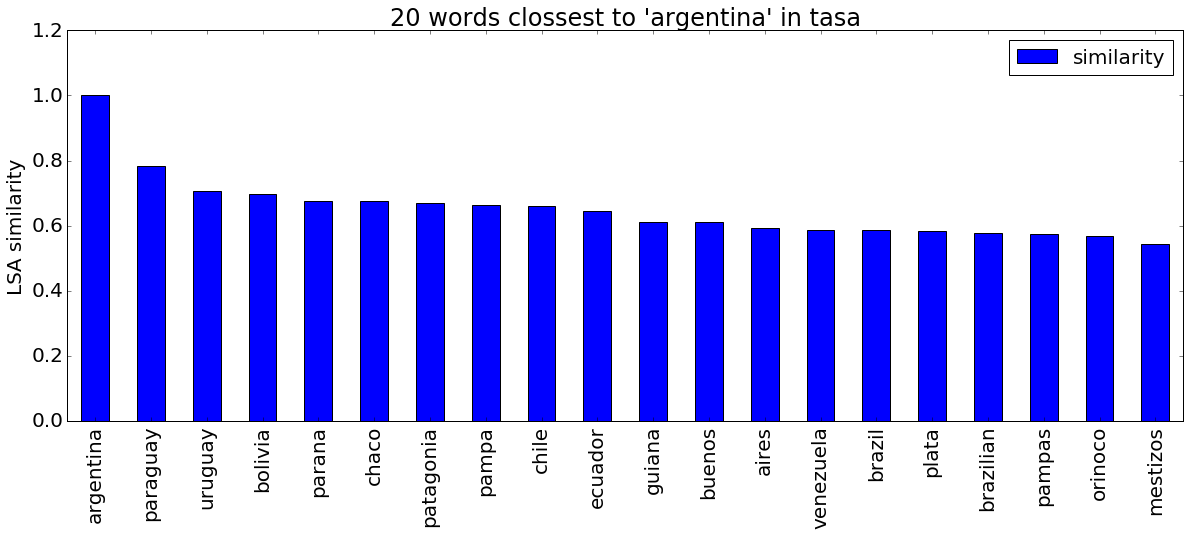

In [31]:
# Grafico
plt.rcParams.update({'font.size': 20, 'legend.fontsize': 20})
df_order.plot(kind='bar',figsize=(20,7))
plt.ylabel("LSA similarity")
plt.title(str(n) + " words clossest to '"+target_word+"' in tasa")
plt.show()

# Word2vec

### El corpus se subdivide por oraciones

In [80]:
corpus_file = open("tasa", "r").read()
documents2 = corpus_file.split("[S]")
parentesis = re.compile("[\[].*[\]]")
regexp_num = re.compile(r"\s\d+[.,]?\d*\s")
stoplist = stopwords.words('english')
texts2 = [[word for word in re.split(r'\W+'
                                    ,regexp_num.sub(" num ", parentesis.sub("", document).lower())) if word not in stoplist and word.isalpha()] for document in documents2]


In [81]:
# filtro oraciones con muy pocas palabras
texts2 = [text for text in texts2 if len(text)>=2] 

In [82]:
texts2[:3] # primeras 3 oraciones del corpus

[['first', 'americans'],
 ['many',
  'many',
  'years',
  'ago',
  'perhaps',
  'num',
  'years',
  'ago',
  'life',
  'different',
  'today'],
 ['time', 'earth', 'grip', 'last', 'ice', 'age']]

In [41]:
# "window" es el tamaño de la ventana a utilizar. window=10 usa 10 palabras a la iquierda y diez a la derecha
# "n_dim" es la dimension del espacio vectorial 
# "workers" es el numero de nucleos a utilizar. Para esta implementacion en paralelo hace falta tener instalado Cython) 
# word2vec filtra las palabras que aparezcan una fraccion de veces (respecto el total del corpus) mayor a "sample"
# word2vec filtra las palabras con frequencia menor a "min_count" 
# Corro el modelo Skipgram (sg=1), para correr el CBOW (sg=0)
# para mas detalle: https://radimrehurek.com/gensim/models/word2vec.html
n_dim =20
w2v_model = Word2Vec(texts2, workers=4,size=n_dim, min_count = 10, window = 10, sample = 1e-3,negative=10,sg=1)
w2v_model.save("word2vec_tasa")  # save model
#w2v_model = Word2Vec.load("word2vec_tasa")  # load model

In [45]:
# El output del word2vec son numpy arrays 
w2v_model[["good"]]

array([[ 0.37684363, -0.48677438,  0.33767587, -0.51624858, -0.09266331,
        -0.67752743, -0.08641163, -0.75592393, -0.15001123,  0.12136961,
         1.23386681,  0.56546479,  0.0498248 , -0.31030723, -0.32469267,
         0.12028261]], dtype=float32)

In [46]:
w2v_model.most_similar(positive=['argentina'], negative=[], topn=10)

[('chile', 0.9720770120620728),
 ('brazil', 0.9637871384620667),
 ('algeria', 0.957870364189148),
 ('uruguay', 0.9558573365211487),
 ('ghana', 0.950215756893158),
 ('venezuela', 0.9469854235649109),
 ('northeastern', 0.9466391801834106),
 ('thailand', 0.9412941336631775),
 ('honduras', 0.9373484253883362),
 ('nigeria', 0.9350093007087708)]

In [48]:
w2v_model.n_similarity(["good","bad"], ["bad"])

0.97456248317940997